In [8]:
import mlflow
import mlflow.tensorflow
from dust_extinction.parameter_averages import CCM89
import astropy.units as u
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from datetime import datetime

os.environ["KERAS_BACKEND"] = "tensorflow"

import tensorflow as tf
import keras
from keras import ops
from keras import layers
from astropy.io import fits
from astropy.table import Table
import numpy as np
import matplotlib.pyplot as plt
import requests
from scipy.interpolate import interp1d
import glob
from scipy import interpolate

from SpectraVAE import SpectraVAE
from BandPassVAE import BandPassVAE
from ParamVAE import ParamVAE
from ParamVAEapply import ParamVAEapply
from validate_HSC import validate_HSC


now = datetime.now()
date_str = now.strftime("%Y%m%d%H%M%S")

print(date_str)

fig_path = "/data/kirg/MMVAE/MLFlow"
weight_path = os.path.join("/data/kirg/MMVAE/cigale/", date_str)
os.makedirs(weight_path, exist_ok=True)

20251028120027


In [9]:
from tensorflow.python.client import device_lib

devices = device_lib.list_local_devices()
for device in devices:
    if device.device_type == 'GPU':
        print(device)

In [10]:
beta = np.array([1e-5, 0, 0])

beta = beta / 10.0

epochs = 150
latent_dim = 64
batch_size = 128
n_param = 4
save_train = True
tbl_train_name = 'train_dataset_cigale_tmpl.fits'
tbl_path = weight_path #'/data/kirg/MMVAE/datasets'


In [11]:
from mkdataset_cigale import *
import matplotlib.pyplot as plt
from astropy.table import Table

integrals, params, spectra, wl_spec = mkdataset_cigale(n_z=10, z_min=-0.20, z_max=1.50,
                                                       perturbation_sigmas = [0.001] * 5,
                                                       inp_file='exp_cigale_noeml.fits')
params[:, 1] = np.log10(params[:, 1])
params[:, 2] *=0.1

1000


In [12]:
perm = np.random.permutation(len(integrals))

# Apply the same permutation to all three
integrals_shuffled = integrals[perm]
params_shuffled = params[perm]
spectra_shuffled = spectra[perm]

# Postprocessing (params normalization already done in DatasetBuilder)
# Normalize spectra (just in case, or omit if confident)
#spectra /= np.max(spectra, axis=1)[:, None]


if save_train:
    tbl = Table([integrals_shuffled, params_shuffled, spectra_shuffled], names=('SED', 'Param', 'Spec'))
    tbl.write(os.path.join(tbl_path, tbl_train_name), overwrite=True)

In [25]:
def call(self, data):
    data_in  = data
    z_mean, z_log_var, z = self.encoder(data_in)
    reconstruction = self.decoder(z)
    return reconstruction

def apply(self, data):
    data_in = data
    z_mean, z_log_var, z = self.encoder(data_in)
    reconstruction = self.decoder(z)
    return (z_mean, z_log_var, z, reconstruction)

def train_step(self, data):
    (data_in, data_out) = data[0]
    with tf.GradientTape() as tape:
        (z_mean, z_log_var, z, reconstruction) = self.apply(data_in)
        
        reconstruction_loss = ops.mean(
            tf.keras.backend.square(data_out - reconstruction)
            #tf.keras.backend.square(data_out - reconstruction)
        )
                    
        kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
        kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
        total_loss = reconstruction_loss + kl_loss*self.beta
    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    self.total_loss_tracker.update_state(total_loss)
    self.reconstruction_loss_tracker.update_state(reconstruction_loss)
    self.kl_loss_tracker.update_state(kl_loss)
    return {
        "loss": total_loss,
        "reconstruction_loss": reconstruction_loss,
        "kl_loss": kl_loss,
   }

def test_step(self, data):
    print(data)
    (data_in, data_out) = data[0]
    (z_mean, z_log_var, z, reconstruction) = self.apply(data_in)
    reconstruction_loss = ops.mean(
        tf.keras.backend.square(data_out - reconstruction)
        #tf.keras.backend.square(data_out - reconstruction)
    )
    kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
    kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
    total_loss = reconstruction_loss + kl_loss*self.beta
    return {
        "loss": total_loss,
        "reconstruction_loss": reconstruction_loss,
        "kl_loss": kl_loss,
    }


In [26]:
import types

spvae = SpectraVAE(100, latent_dim, beta=beta[0])
spvae.compile(optimizer=keras.optimizers.Adam())
spvae(tf.zeros((1, 100)))




parvae = ParamVAE(100, latent_dim, 
                  spvae, beta=beta[2],
                  n_param=n_param,
                  wei = [1,1,1,1])
parvae.compile(optimizer=keras.optimizers.Adam())
parvae(tf.zeros((1, 100)))


bpvae = BandPassVAE(5,latent_dim, spvae, beta=beta[1])
bpvae.compile(optimizer=keras.optimizers.Adam())
bpvae(tf.zeros((1, 5)))


parvaeapply = ParamVAEapply(5,latent_dim, bpvae, parvae, beta=beta[2])



parvaeapply.apply = types.MethodType(apply, parvaeapply)
parvaeapply.train_step = types.MethodType(train_step, parvaeapply)
parvaeapply.test_step = types.MethodType(test_step, parvaeapply)


parvaeapply.encoder.trainable = True
parvaeapply.decoder.trainable = True




parvaeapply.compile(optimizer=keras.optimizers.Adam())
parvaeapply(tf.zeros((1, 5)))


hsp=parvaeapply.fit((integrals, params), epochs=epochs, batch_size=batch_size, validation_split=0.2)


Epoch 1/150


/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_342']
Received: inputs=Tensor(shape=(1, 100))
  warnings.warn(msg)
/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_368']
Received: inputs=Tensor(shape=(1, 5))
  warnings.warn(msg)
/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_368']
Received: inputs=Tensor(shape=(128, 5))
  warnings.warn(msg)


573/625 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - kl_loss: 15.4948 - loss: 0.2319 - reconstruction_loss: 0.2319((<tf.Tensor 'data:0' shape=(None, 5) dtype=float32>, <tf.Tensor 'data_1:0' shape=(None, 4) dtype=float32>),)
625/625 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - kl_loss: 15.5824 - loss: 0.2269 - reconstruction_loss: 0.2269 - val_kl_loss: 16.6522 - val_loss: 0.6518 - val_reconstruction_loss: 0.6518
Epoch 2/150
  1/625 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - kl_loss: 16.7725 - loss: 0.1740 - reconstruction_loss: 0.1740

/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_368']
Received: inputs=Tensor(shape=(None, 5))
  warnings.warn(msg)


625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - kl_loss: 17.2526 - loss: 0.1725 - reconstruction_loss: 0.1725 - val_kl_loss: 17.3600 - val_loss: 0.6075 - val_reconstruction_loss: 0.6075
Epoch 3/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - kl_loss: 17.2811 - loss: 0.1726 - reconstruction_loss: 0.1726 - val_kl_loss: 17.7290 - val_loss: 0.6476 - val_reconstruction_loss: 0.6476
Epoch 4/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - kl_loss: 16.0682 - loss: 0.1726 - reconstruction_loss: 0.1726 - val_kl_loss: 15.6365 - val_loss: 0.6189 - val_reconstruction_loss: 0.6189
Epoch 5/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - kl_loss: 15.2189 - loss: 0.1726 - reconstruction_loss: 0.1726 - val_kl_loss: 14.3119 - val_loss: 0.6427 - val_reconstruction_loss: 0.6427
Epoch 6/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - kl_loss: 23.0924 - loss: 0.1559 - reconstruction_loss: 0.1559 - val_kl_loss: 44.8078 - val_loss: 0.4755 - val_reconstruction_loss: 0.4755
Epoch 7/150
625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms

/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_368']
Received: inputs=Tensor(shape=(100000, 5))
  warnings.warn(msg)


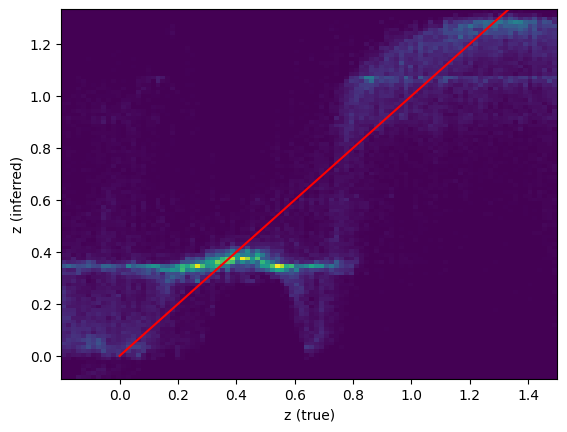

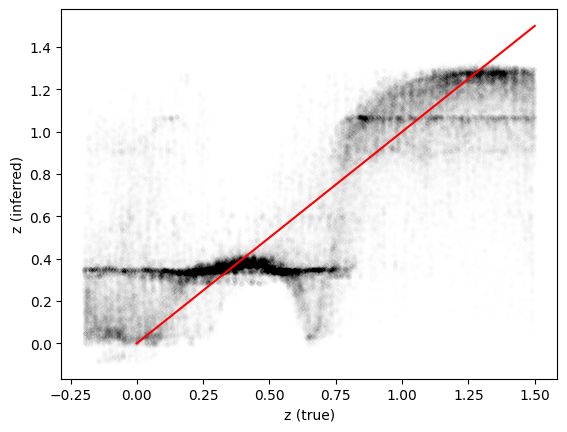

In [30]:
s = parvaeapply(integrals)
s_sel = s
params_sel = params
plt.hist2d(params_sel[:, 0], s_sel[:, 0], bins=100)
plt.xlabel('z (true)')
plt.ylabel('z (inferred)')
plt.plot([0,1.5], [0,1.5], color='red')
plt.show()

plt.plot(params_sel[:, 0], s_sel[:, 0], 'k.', alpha=0.002)
plt.xlabel('z (true)')
plt.ylabel('z (inferred)')
plt.plot([0,1.5], [0,1.5], color='red')
plt.show()


/home/kirg/MMVAE/vae_mpoe/validate_HSC.py:25: UserWarning: Warning: converting a masked element to nan.
  mags = mags = np.array([r['g_kronflux_mag'], r['r_kronflux_mag'], r['i_kronflux_mag'], r['z_kronflux_mag'], r['y_kronflux_mag']])
/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_368']
Received: inputs=Tensor(shape=(174304, 5))
  warnings.warn(msg)


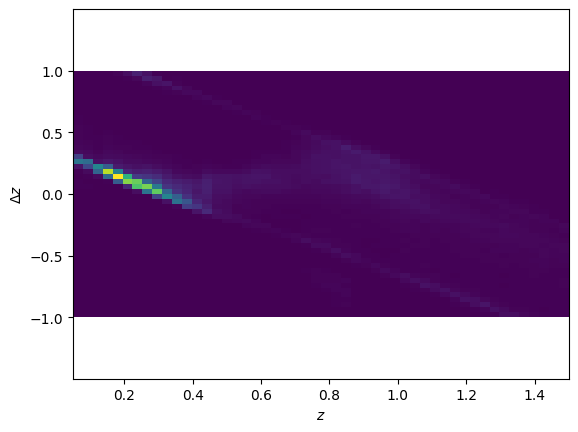

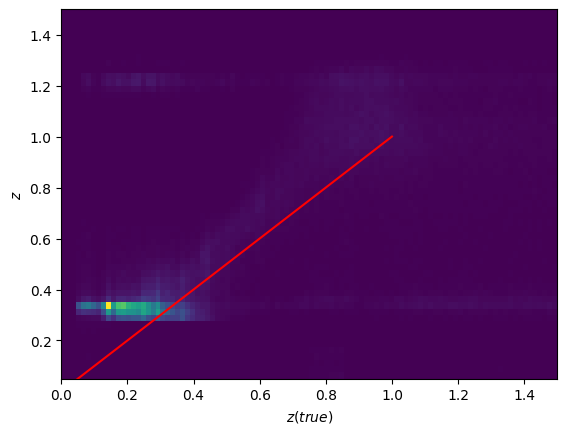

/home/kirg/envs/envp3.12/lib/python3.12/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_368']
Received: inputs=Tensor(shape=(160762, 5))
  warnings.warn(msg)


tf.Tensor([ 1.1547213   1.7760556   0.7420275  -0.01302065], shape=(4,), dtype=float32) 0.822681493570212


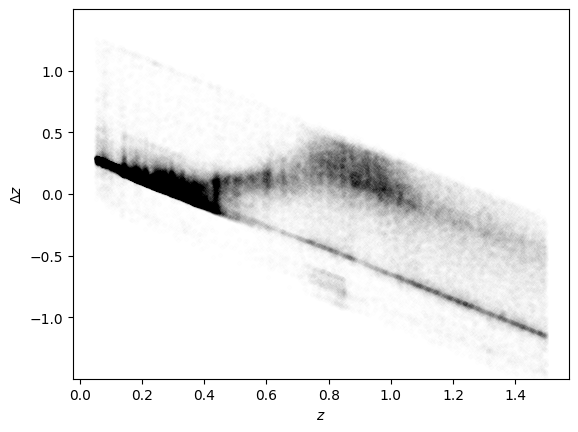

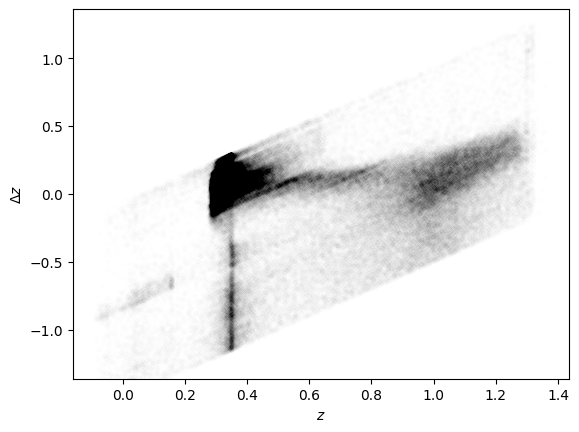

[0.82268149 0.78530661 0.78958418 ... 0.0872988  0.0873343  0.15478596]


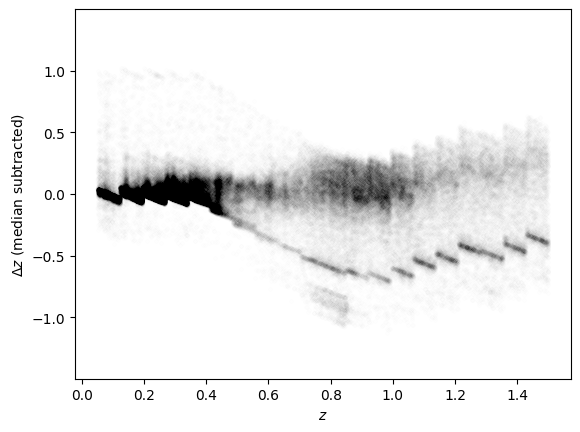

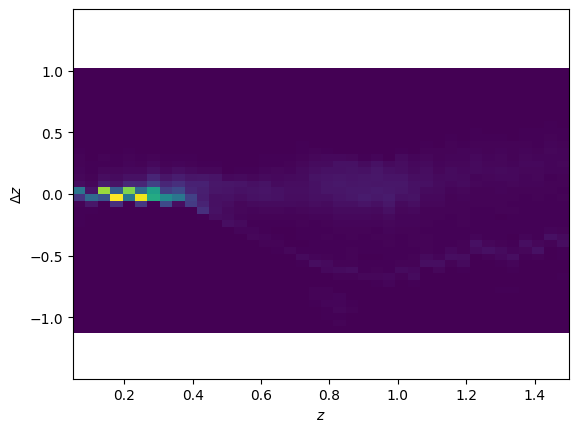

0.08437658764971312 -0.0039767027 0.027779952
0.1609518218259867 -0.003266096 0.031173894
0.23224574072286575 -0.0044722185 0.03261242
0.3005030542082366 -0.008053154 0.039460022
0.3729144105629544 -0.0097691715 0.054901678
0.4446966716478358 -0.005953461 0.106446005
0.5197335356044075 -0.0046128333 0.13217416
0.5938853787654966 0.015281111 0.095898956
0.6671444408673443 0.016278565 0.11834967
0.7426516752135683 0.017163634 0.24609172
0.8132416903009981 0.06664154 0.14138272
0.8829454610983705 0.037297398 0.1394871
0.9562775539020024 0.029373944 0.13704994
1.0278397035317333 0.049399376 0.14776309
1.098601086032606 0.008282244 0.3062613
1.173570685105528 0.010891318 0.32416296
1.2449487916804096 0.0013615489 0.33581316
1.3181538923260399 0.0051463842 0.34815934
1.3911223519634741 0.00015753508 0.34369153
1.4637685905658395 0.0 0.34485963


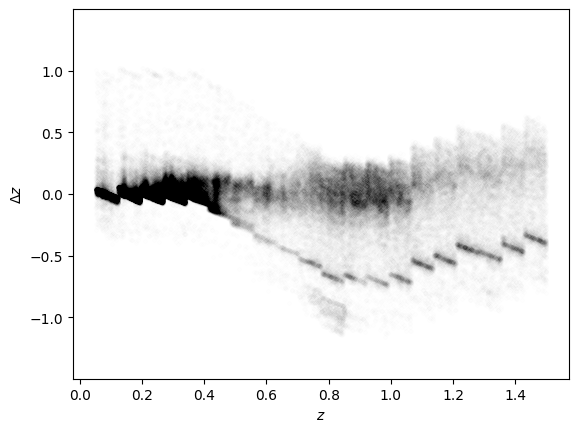

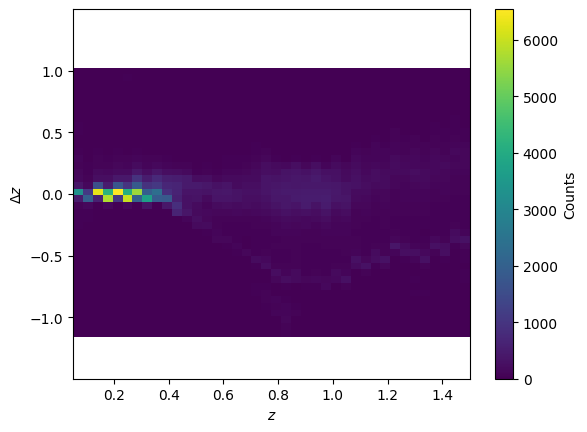

In [31]:
from validate_HSC import validate_HSC


filename = ['test1.png',
           'test2.png',
           'test3.png',
           'test4.png',
           'test5.png',
           'test6.png',
           'test7.png']

validate_HSC(parvaeapply, filename, fig_path='/home/kirg/fig_test',
             show = [True, True, True, True, True, True, True],
             hsc_table='DESI_DR1_HSCSSP_clean_v2.fits', 
             z_min=0.05, z_max=1.50,
             hist2d_zz_kwargs=dict(bins=100, range=[[0, 1.5], [-0.5, 1.5+0.5]]))
